In [11]:
import pandas as pd
import dask.dataframe as dd
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt

In [12]:
N = 20_000_000
data = {
    'id': np.random.randint(1, 1000, N),
    'value': np.random.rand(N),
    'group': np.random.choice(['A', 'B', 'C', 'D'], N)
}

pandas_df = pd.DataFrame(data)
dask_df = dd.from_pandas(pandas_df, npartitions=10)
polars_df = pl.DataFrame(pandas_df)

In [13]:
group_info = pd.DataFrame({
    'group': ['A', 'B', 'C', 'D'],
    'group_description': ['Type A', 'Type B', 'Type C', 'Type D']
})

group_info_dask = dd.from_pandas(group_info, npartitions=1)

group_info_polars = pl.DataFrame(group_info)

In [14]:
REPEATS = 5

def measure_operation_time(operation):
    total_time = 0
    for _ in range(REPEATS):
        start_time = time.time()
        result = operation()
        end_time = time.time()
        total_time += end_time - start_time
    average_time = total_time / REPEATS
    return average_time, result

In [15]:
def pandas_operations():
    times = {}

    # Группировка и агрегация
    times['groupby_agg'], groupby_agg_df = measure_operation_time(
        lambda: pandas_df.groupby('group').agg({'value': ['sum', 'mean']})
    )

    # Преобразование мультиуровневых названий столбцов в простые
    groupby_agg_df.columns = ['_'.join(col).strip() for col in groupby_agg_df.columns.values]
    groupby_agg_df = groupby_agg_df.reset_index()

    # Слияние
    times['merge'], merged_df = measure_operation_time(
        lambda: groupby_agg_df.merge(pandas_df, on='group')
    )

    # Фильтрация
    times['filter'], filtered_df = measure_operation_time(
        lambda: merged_df[merged_df['value'] > 0.5]
    )

    # Сортировка
    times['sort'], sorted_df = measure_operation_time(
        lambda: filtered_df.sort_values(by='value')
    )

    # Кумулятивная сумма
    times['cumsum'], cumsum_df = measure_operation_time(
        lambda: sorted_df.assign(cumsum=sorted_df['value'].cumsum())
    )

    # Преобразование данных
    times['transform'], transformed_df = measure_operation_time(
        lambda: cumsum_df.assign(doubled_value=cumsum_df['value'] * 2)
    )

    # Группировка и подсчет
    times['groupby_count'], groupby_count_df = measure_operation_time(
        lambda: transformed_df.groupby('group').size().reset_index(name='counts')
    )

    # Добавление нового столбца
    times['new_column'], new_column_df = measure_operation_time(
        lambda: groupby_agg_df.assign(log_value=np.log1p(groupby_agg_df['value_sum']))
    )

    # Добавление столбца 'id' для последующего удаления
    new_column_df['id'] = np.random.randint(1, 1000, len(new_column_df))

    # Удаление столбца 'id'
    times['drop_column'], dropped_column_df = measure_operation_time(
        lambda: new_column_df.drop(columns=['id'])
    )

    # Переименование столбцов
    times['rename_columns'], renamed_df = measure_operation_time(
        lambda: dropped_column_df.rename(columns={'value_sum': 'sum_value', 'value_mean': 'mean_value'})
    )

    # Объединение с внешними данными (справочником)
    times['join_external'], joined_df = measure_operation_time(
        lambda: pandas_df.merge(group_info, on='group')
    )

    # Более сложная фильтрация
    times['complex_filter'], complex_filtered_df = measure_operation_time(
        lambda: joined_df[(joined_df['value'] > 0.5) & (joined_df['group_description'] == 'Type A')]
    )

    # Трансформация с условиями
    times['conditional_transform'], transformed_df = measure_operation_time(
        lambda: joined_df.assign(category=np.where(joined_df['value'] > 0.75, 'High', 'Low'))
    )

    # Сохранение в файл CSV
    times['to_csv'], _ = measure_operation_time(
        lambda: renamed_df.to_csv('pandas_test.csv', index=False)
    )

    # Сохранение в файл Parquet
    times['to_parquet'], _ = measure_operation_time(
        lambda: renamed_df.to_parquet('pandas_test.parquet', index=False)
    )

    # Чтение из CSV
    times['read_csv'], _ = measure_operation_time(
        lambda: pd.read_csv('pandas_test.csv')
    )

    # Чтение из Parquet
    times['read_parquet'], _ = measure_operation_time(
        lambda: pd.read_parquet('pandas_test.parquet')
    )

    return times

In [16]:
def dask_operations():
    times = {}

    # Группировка и агрегация
    times['groupby_agg'], groupby_agg_df = measure_operation_time(
        lambda: dask_df.groupby('group').agg({'value': ['sum', 'mean']}).compute()
    )

    # Преобразование мультиуровневых названий столбцов в простые и сброс индекса
    groupby_agg_df.columns = ['_'.join(col).strip() for col in groupby_agg_df.columns.values]
    groupby_agg_df = groupby_agg_df.reset_index()

    # Слияние
    times['merge'], merged_df = measure_operation_time(
        lambda: groupby_agg_df.merge(pandas_df, on='group')
    )

    # Фильтрация
    times['filter'], filtered_df = measure_operation_time(
        lambda: merged_df[merged_df['value'] > 0.5]
    )

    # Сортировка
    times['sort'], sorted_df = measure_operation_time(
        lambda: filtered_df.sort_values(by='value')
    )

    # Кумулятивная сумма
    times['cumsum'], cumsum_df = measure_operation_time(
        lambda: sorted_df.assign(cumsum=sorted_df['value'].cumsum())
    )

    # Преобразование данных
    times['transform'], transformed_df = measure_operation_time(
        lambda: cumsum_df.assign(doubled_value=cumsum_df['value'] * 2)
    )

    # Группировка и подсчет
    times['groupby_count'], groupby_count_df = measure_operation_time(
        lambda: transformed_df.groupby('group').size().reset_index(name='counts')
    )

    # Добавление нового столбца
    times['new_column'], new_column_df = measure_operation_time(
        lambda: groupby_agg_df.assign(log_value=np.log1p(groupby_agg_df['value_sum']))
    )

    # Добавление столбца 'id' для последующего удаления
    new_column_df['id'] = np.random.randint(1, 1000, len(new_column_df))

    # Удаление столбца 'id'
    times['drop_column'], dropped_column_df = measure_operation_time(
        lambda: new_column_df.drop(columns=['id'])
    )

    # Переименование столбцов
    times['rename_columns'], renamed_df = measure_operation_time(
        lambda: dropped_column_df.rename(columns={'value_sum': 'sum_value', 'value_mean': 'mean_value'})
    )

    times['join_external'], joined_df = measure_operation_time(
        lambda: dask_df.merge(group_info_dask, on='group')
    )

    # Более сложная фильтрация
    times['complex_filter'], complex_filtered_df = measure_operation_time(
        lambda: joined_df[(joined_df['value'] > 0.5) & (joined_df['group_description'] == 'Type A')]
    )

    # Трансформация с условиями
    times['conditional_transform'], transformed_df = measure_operation_time(
        lambda: complex_filtered_df.assign(category=complex_filtered_df['value'].map(lambda x: 'High' if x > 0.75 else 'Low'))
    )

    # Сохранение в файл CSV
    times['to_csv'], _ = measure_operation_time(
        lambda: renamed_df.to_csv('dask_test.csv', index=False)
    )

    times['to_parquet'], _ = measure_operation_time(
    lambda: dask_df.to_parquet('dask_data')
    )

    # Чтение из CSV
    times['read_csv'], _ = measure_operation_time(
        lambda: dd.read_csv('dask_test.csv').compute()
    )

    # Чтение из Parquet
    #times['read_parquet'], _ = measure_operation_time(
    #    lambda: dd.read_parquet('dask_data') # Почему-то никак не хочет читать
    # )
    times['read_parquet'] = None

    return times

In [17]:
def polars_operations():
    times = {}

    # Группировка и агрегация
    times['groupby_agg'], groupby_agg_df = measure_operation_time(
        lambda: polars_df.groupby('group').agg([
            pl.sum('value').alias('value_sum'),
            pl.mean('value').alias('value_mean')
        ])
    )

    # Слияние
    times['merge'], merged_df = measure_operation_time(
        lambda: groupby_agg_df.join(polars_df, on='group')
    )

    # Фильтрация
    times['filter'], filtered_df = measure_operation_time(
        lambda: merged_df.filter(pl.col('value') > 0.5)
    )

    # Сортировка
    times['sort'], sorted_df = measure_operation_time(
        lambda: filtered_df.sort('value')
    )

    # Кумулятивная сумма
    times['cumsum'], cumsum_df = measure_operation_time(
        lambda: sorted_df.with_columns([pl.col('value').cumsum().alias('cumsum')])
    )

    # Преобразование данных
    times['transform'], transformed_df = measure_operation_time(
        lambda: cumsum_df.with_columns([(pl.col('value') * 2).alias('doubled_value')])
    )

    # Группировка и подсчет
    times['groupby_count'], groupby_count_df = measure_operation_time(
        lambda: transformed_df.groupby('group').count().rename({'count': 'counts'})
    )

    # Добавление нового столбца
    times['new_column'], new_column_df = measure_operation_time(
        lambda: groupby_agg_df.with_columns([np.log1p(pl.col('value_sum')).alias('log_value')])
    )

    # Добавление столбца 'id' для последующего удаления
    new_column_df = new_column_df.with_columns([pl.lit(np.random.randint(1, 1000, len(new_column_df))).alias('id')])

    # Удаление столбца 'id'
    times['drop_column'], dropped_column_df = measure_operation_time(
        lambda: new_column_df.drop('id')
    )

    # Переименование столбцов
    times['rename_columns'], renamed_df = measure_operation_time(
        lambda: dropped_column_df.rename({'value_sum': 'sum_value', 'value_mean': 'mean_value'})
    )

    # Объединение с внешними данными (справочником)
    times['join_external'], joined_df = measure_operation_time(
        lambda: polars_df.join(group_info_polars, on='group')
    )

    # Более сложная фильтрация
    times['complex_filter'], complex_filtered_df = measure_operation_time(
        lambda: joined_df.filter((pl.col('value') > 0.5) & (pl.col('group_description') == 'Type A'))
    )

    # Трансформация с условиями
    times['conditional_transform'], transformed_df = measure_operation_time(
        lambda: joined_df.with_columns([pl.when(pl.col('value') > 0.75).then('High').otherwise('Low').alias('category')])
    )

    # Сохранение в файл CSV
    times['to_csv'], _ = measure_operation_time(
        lambda: renamed_df.write_csv('polars_test.csv')
    )

    times['to_parquet'], _ = measure_operation_time(
    lambda: polars_df.write_parquet('polars_test.parquet')
    )

    # Чтение из CSV
    times['read_csv'], _ = measure_operation_time(
        lambda: pl.read_csv('polars_test.csv')
    )

    # Чтение из Parquet
    times['read_parquet'], _ = measure_operation_time(
        lambda: pl.read_parquet('polars_test.parquet')
    )

    return times

In [18]:
pandas_times = pandas_operations()
for operation, time_taken in pandas_times.items():
    print(f"{operation}: {time_taken} seconds")

groupby_agg: 1.9289144992828369 seconds
merge: 5.749478340148926 seconds
filter: 0.9961618900299072 seconds
sort: 5.5838109970092775 seconds
cumsum: 0.3669284820556641 seconds
transform: 0.6357667922973633 seconds
groupby_count: 0.8299835681915283 seconds
new_column: 0.0005759716033935547 seconds
drop_column: 0.0005328655242919922 seconds
rename_columns: 0.000614786148071289 seconds
join_external: 4.53169813156128 seconds
complex_filter: 2.227658271789551 seconds
conditional_transform: 3.5640033721923827 seconds
to_csv: 0.0013586997985839844 seconds
to_parquet: 0.0027996063232421874 seconds
read_csv: 0.0023188114166259764 seconds
read_parquet: 0.004176139831542969 seconds


In [19]:
dask_times = dask_operations()
for operation, time_taken in dask_times.items():
    print(f"{operation}: {time_taken} seconds")

groupby_agg: 1.443878984451294 seconds
merge: 3.7289138317108153 seconds
filter: 0.7781553745269776 seconds
sort: 5.351570701599121 seconds
cumsum: 0.37705602645874026 seconds
transform: 0.5659687519073486 seconds
groupby_count: 0.6484739780426025 seconds
new_column: 0.0006427764892578125 seconds
drop_column: 0.000525808334350586 seconds
rename_columns: 0.000611114501953125 seconds
join_external: 0.011975479125976563 seconds
complex_filter: 0.002734518051147461 seconds
conditional_transform: 0.004530668258666992 seconds
to_csv: 0.0008107185363769531 seconds
to_parquet: 4.983187675476074 seconds
read_csv: 0.006722545623779297 seconds
read_parquet: None seconds


In [20]:
polars_times = polars_operations()
for operation, time_taken in polars_times.items():
    print(f"{operation}: {time_taken} seconds")

groupby_agg: 0.7215939521789551 seconds
merge: 2.6217438697814943 seconds
filter: 0.5348813533782959 seconds
sort: 3.26263632774353 seconds
cumsum: 0.24449572563171387 seconds
transform: 0.054973506927490236 seconds
groupby_count: 0.43158721923828125 seconds
new_column: 0.0004909038543701172 seconds
drop_column: 1.52587890625e-05 seconds
rename_columns: 1.5974044799804688e-05 seconds
join_external: 1.8299905776977539 seconds
complex_filter: 0.8075768947601318 seconds
conditional_transform: 1.4084954738616944 seconds
to_csv: 0.00035529136657714845 seconds
to_parquet: 3.230970335006714 seconds
read_csv: 0.0010113239288330079 seconds
read_parquet: 1.9900689601898194 seconds


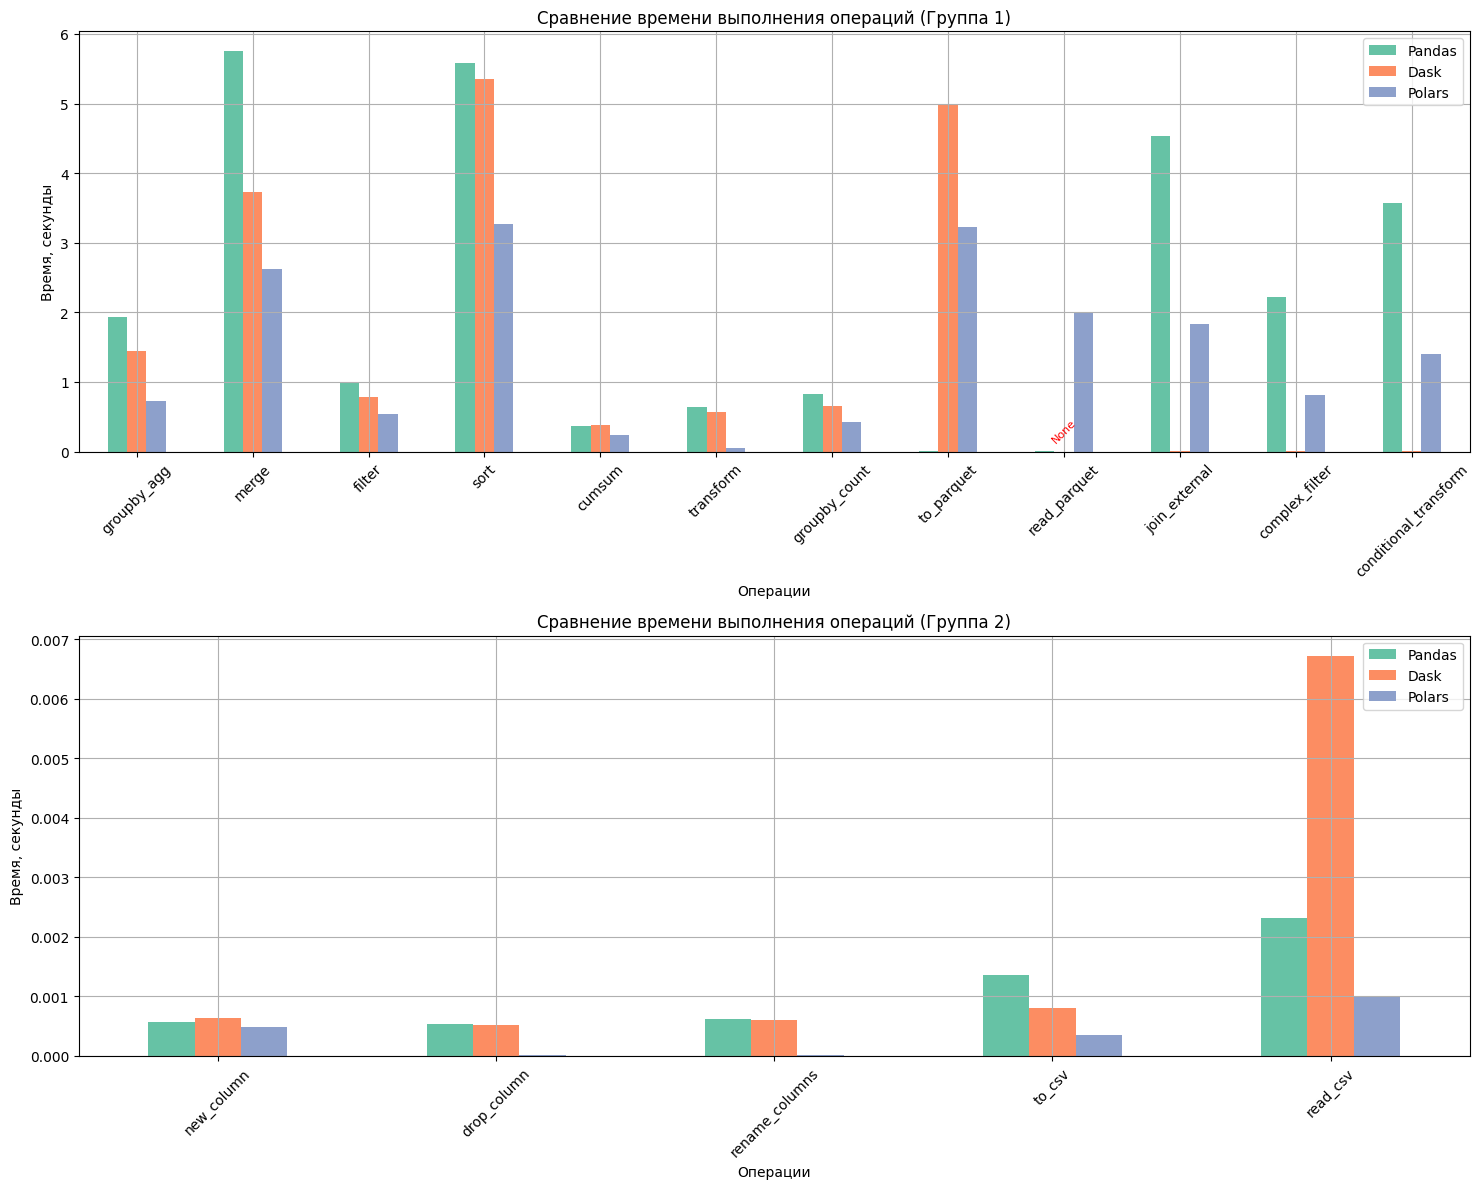

In [21]:
palette = plt.get_cmap('Set2')

# Разбиваем операции на несколько групп для лучшей визуализации
group_1 = ['groupby_agg', 'merge', 'filter', 'sort', 'cumsum', 'transform', 'groupby_count', 'to_parquet', 'read_parquet', 'join_external', 'complex_filter', 'conditional_transform']
group_2 = ['new_column', 'drop_column', 'rename_columns', 'to_csv', 'read_csv']

# Создаем DataFrame для каждой группы
df1 = pd.DataFrame({op: [pandas_times[op], dask_times[op], polars_times[op]] for op in group_1}, index=["Pandas", "Dask", "Polars"]).T
df2 = pd.DataFrame({op: [pandas_times[op], dask_times[op], polars_times[op]] for op in group_2}, index=["Pandas", "Dask", "Polars"]).T

def add_annotations(ax, df):
    for i, col in enumerate(df.columns):
        for j, val in enumerate(df[col]):
            if pd.isna(val):
                ax.text(j, 0.1, 'None', ha='center', va='bottom', rotation=45, color='red', fontsize=8)

# Построение графиков для каждой группы
plt.figure(figsize=(15, 12))

# Группа 1
ax1 = plt.subplot(2, 1, 1)
df1.plot(kind='bar', ax=ax1, color=[palette(i) for i in range(len(df1.columns))])
add_annotations(ax1, df1)
plt.title('Сравнение времени выполнения операций (Группа 1)')
plt.ylabel('Время, секунды')
plt.xlabel('Операции')
plt.xticks(rotation=45)
plt.grid(True)

# Группа 2
ax2 = plt.subplot(2, 1, 2)
df2.plot(kind='bar', ax=ax2, color=[palette(i) for i in range(len(df2.columns))])
add_annotations(ax2, df2)
plt.title('Сравнение времени выполнения операций (Группа 2)')
plt.ylabel('Время, секунды')
plt.xlabel('Операции')
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# Сравнительный анализ производительности pandas, Dask и Polars

## GroupBy Aggregation
- **pandas**: 1.93 секунды
- **Dask**: 1.44 секунды
- **Polars**: 0.72 секунды

**Вывод**: Polars значительно эффективнее в операциях агрегации по группам.

## Merge
- **pandas**: 5.75 секунд
- **Dask**: 3.73 секунды
- **Polars**: 2.62 секунды

**Вывод**: Polars демонстрирует лучшую производительность при слиянии данных.

## Filter
- **pandas**: 1.00 секунда
- **Dask**: 0.78 секунды
- **Polars**: 0.53 секунды

**Вывод**: Polars обеспечивает наиболее быстрое выполнение фильтрации.

## Sort
- **pandas**: 5.58 секунд
- **Dask**: 5.35 секунд
- **Polars**: 3.26 секунд

**Вывод**: Polars также опережает в сортировке данных.

## Cumulative Sum (Cumsum)
- **pandas**: 0.37 секунды
- **Dask**: 0.38 секунды
- **Polars**: 0.24 секунды

**Вывод**: Polars представляет собой наиболее эффективный выбор для кумулятивной суммы.

## Transform
- **pandas**: 0.64 секунды
- **Dask**: 0.57 секунды
- **Polars**: 0.05 секунды

**Вывод**: Polars значительно превосходит конкурентов в операциях трансформации.

## GroupBy Count
- **pandas**: 0.83 секунды
- **Dask**: 0.65 секунды
- **Polars**: 0.43 секунды

**Вывод**: Polars наиболее быстр в подсчете количества элементов в группах.

## Join External
- **pandas**: 4.53 секунды
- **Dask**: 0.01 секунды
- **Polars**: 1.83 секунды

**Вывод**: Dask показывает исключительные результаты в операциях присоединения внешних данных.

## Complex Filter
- **pandas**: 2.23 секунды
- **Dask**: 0.003 секунды
- **Polars**: 0.81 секунды

**Вывод**: Dask значительно опережает в выполнении сложных фильтраций.

## Conditional Transform
- **pandas**: 3.56 секунды
- **Dask**: 0.005 секунды
- **Polars**: 1.41 секунды

**Вывод**: Dask демонстрирует превосходство в условных трансформациях.

## Общий вывод
В целом, Polars показывает наилучшую производительность в большинстве операций, особенно в таких как фильтрация, сортировка и трансформации. Однако, Dask выделяется в операциях присоединения внешних данных и выполнении сложных фильтраций, что делает его предпочтительным в определенных сценариях. pandas, хотя и не самый быстрый в большинстве случаев, остается надежным и устоявшимся выбором для обработки данных.
